<a href="https://colab.research.google.com/github/aadumbuya/chat_bot/blob/main/English_Gramma_Chatbot_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Installing the Hugging Face PyTorch Interface for Bert
!pip install -q transformers

In [ ]:
#Importing the modules
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
#% matplotlib inline
import os
from transformers import BertForSequenceClassification, BertTokenizer

In [ ]:
#Specifying CUDA as the device for Torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
#Loading the Dataset
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [ ]:
df.sample(10)

,sentence_source,label,label_notes,sentence
5622,c_13,1,NaN,everyone should be able to defend herself .
5929,c_13,0,*,the rock placed the sky with the fork .
4582,ks08,1,NaN,i could have little known that more trouble wa...
6323,c_13,1,NaN,heidi thinks that she has won .
4641,ks08,1,NaN,the car has been driven .
2742,l-93,0,*,carmen bought a dress to mary .
6810,m_02,1,NaN,both jane and elizabeth were at home .
1278,r-67,1,NaN,tony has a fiat and yearns for a tall nurse .
4481,ks08,0,*,john expect to must leave .
5699,c_13,1,NaN,we ate at a really fancy restaurant .


In [ ]:
#Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values

#Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [ ]:
#Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [ ]:
#Processing the data
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
#Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [ ]:
#Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
#Converting all the data into torch tensors
# Torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
#Selecting a Batch Size and Creating and Iterator
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
#Transformer Installation
try:
    import transformers
except:
    print("Installing transformers")
    !pip -qq install transformers

In [ ]:
#Bert Configuration
# Initializing a BERT bert-base-uncased style configuration
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
#Loading the Hugging Face Bert Uncased Base Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Changing the weight_decay_rate from 0.1 to 0.2, also weight_decay_rate from 0.0 to 0.1. Inreace the weight_decay_rate from 0.2 to 0.4, weight_decay_rate from 0.1 to 0.2

In [ ]:
#Optimizer Grouped Parameters

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.4},

    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2}
]

Increeasing the epoch from 4 to 5, lr from 2e-5 to 3e-5, eps from 1e-8 to 2e-9. Epoch from 5 to 6, lr from 3e-5 to to 4e-5

In [ ]:
#The Hyperparemeters for the Training Loop

epochs = 6

optimizer = AdamW(optimizer_grouped_parameters,lr = 4e-5, eps = 2e-9)

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#The Training Loop
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for i in trange(epochs, desc="Epoch"):


    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_accuracy=0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs['loss']
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate.
        scheduler.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        logits = outputs["logits"]

        # Calculate training accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        tr_accuracy += tmp_train_accuracy

    avg_train_loss = tr_loss / nb_tr_steps
    avg_train_accuracy = tr_accuracy / nb_tr_steps
    print(f"Epoch {i + 1}:")
    print(f"Train Loss: {avg_train_loss}")
    print(f"Train Accuracy: {avg_train_accuracy}")


    print("Train loss: {}".format(tr_loss/nb_tr_steps))


    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
           # Forward pass, calculate logit predictions
           logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Move logits and labels to CPU
        logits = logits['logits'].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:
Train Loss: 0.08726895605194618
Train Accuracy: 0.9718620331950207
Train loss: 0.08726895605194618


Epoch:  17%|█▋        | 1/6 [02:28<12:24, 148.98s/it]

Validation Accuracy: 0.8063271604938271
Epoch 2:
Train Loss: 0.0929511483948044
Train Accuracy: 0.9680843706777317
Train loss: 0.0929511483948044


Epoch:  33%|███▎      | 2/6 [04:57<09:54, 148.56s/it]

Validation Accuracy: 0.8125
Epoch 3:
Train Loss: 0.052701925901363744
Train Accuracy: 0.9843101659751037
Train loss: 0.052701925901363744


Epoch:  50%|█████     | 3/6 [07:25<07:25, 148.41s/it]

Validation Accuracy: 0.8167438271604938
Epoch 4:
Train Loss: 0.032234435345537
Train Accuracy: 0.9911825726141079
Train loss: 0.032234435345537


Epoch:  67%|██████▋   | 4/6 [09:53<04:56, 148.32s/it]

Validation Accuracy: 0.8182870370370371
Epoch 5:
Train Loss: 0.02010890952320151
Train Accuracy: 0.9934993084370678
Train loss: 0.02010890952320151


Epoch:  83%|████████▎ | 5/6 [12:21<02:28, 148.30s/it]

Validation Accuracy: 0.8252314814814815
Epoch 6:
Train Loss: 0.015063137711601572
Train Accuracy: 0.9954616182572614
Train loss: 0.015063137711601572


Epoch: 100%|██████████| 6/6 [14:50<00:00, 148.34s/it]

Validation Accuracy: 0.8206018518518519


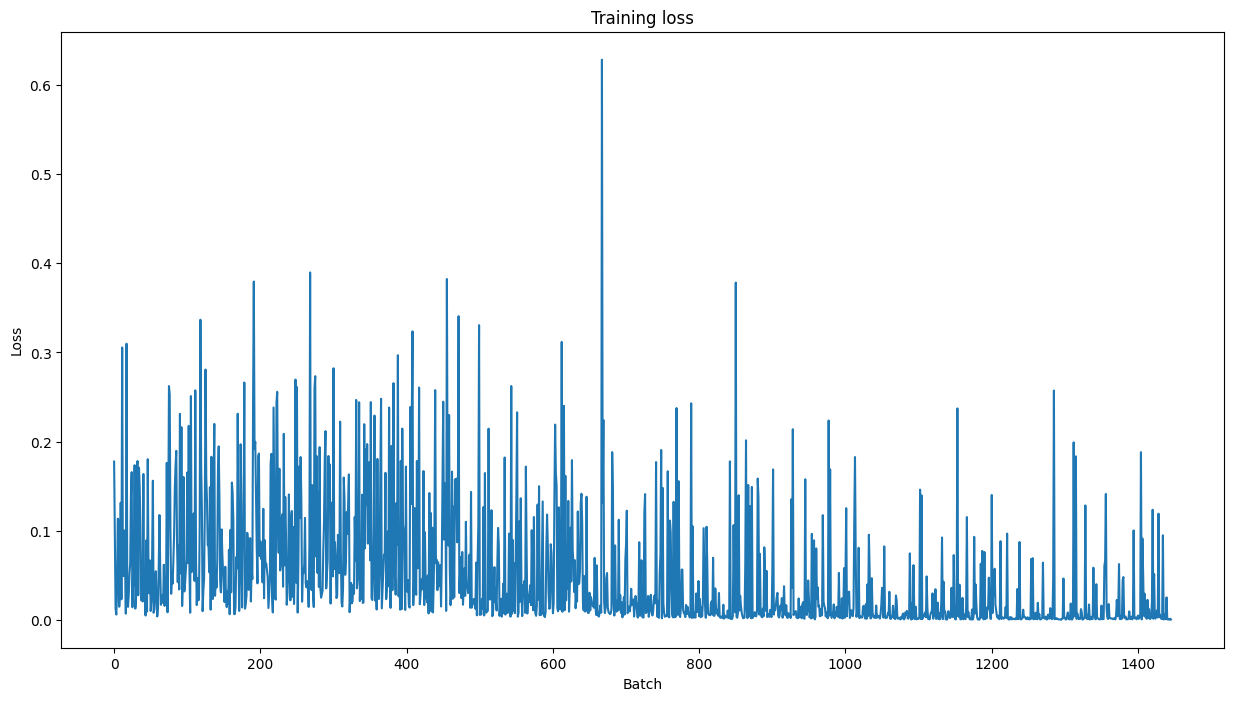

In [46]:
#Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [47]:
#Predicting and Evaluating Using the Hold-out Dataset
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [48]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

In [49]:
#Evaluating Using Matthew's Correlation Coefficient
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i],np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)

In [50]:
#Score of Individual Batches
matthews_set

[0.049286405809014416,
 -0.050964719143762556,
 0.4040950971038548,
 0.2789579047098707,
 0.49517597397212765,
 0.6147253896340708,
 0.3768673314407159,
 0.47519096331149147,
 0.8333333333333334,
 0.7530836820370708,
 0.8459051693633014,
 0.6666666666666666,
 0.8749672939989046,
 0.589872830909857,
 0.38461538461538464,
 0.6457765999379483,
 0.0]

In [51]:
#Matthew's Evaluation on the Whole Dataset
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5270938469686087

In [52]:
# Directory to save the model
output_dir = "./bert_finetuned_model/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")

# Loading the saved model for predictions
def load_model(model_dir):
    model = BertForSequenceClassification.from_pretrained(model_dir)
    tokenizer = BertTokenizer.from_pretrained(model_dir)
    model.to(device)
    return model, tokenizer

# Load the fine-tuned model
loaded_model, loaded_tokenizer = load_model(output_dir)
print("Model loaded successfully!")

# Function to make predictions
def predict(sentence, model, tokenizer):
    model.eval()
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs['logits']
    prediction = torch.argmax(logits, dim=1).item()
    return prediction

# Example usage
example_sentence = "This is an example sentence for testing."
prediction = predict(example_sentence, loaded_model, loaded_tokenizer)
print(f"Predicted label: {prediction}")


Model and tokenizer saved to ./bert_finetuned_model/
Model loaded successfully!
Predicted label: 1
